In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import string
import contextily as cx

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from ast import literal_eval
from hypergas.plume_utils import get_index_nearest, get_wind_azimuth, conish_2d

from shapely.geometry.point import Point
import geopandas as gpd
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
from matplotlib import rcParams
# set basic matplotlib settings
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['tex gyre heros']

font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

In [3]:
ds = xr.open_dataset('../data/Plume_mask/EMIT_L2B_001_20231124T142642_2332809_049.nc')
ds_plume = xr.open_dataset('../data/Plume_mask/EMIT_L3B_001_20231124T142642_2332809_049_plume0.nc')
ds_plume_final = xr.open_dataset('../data/Plume_mask/final/EMIT_L3B_001_20231124T142642_2332809_049_plume0.nc')
df = pd.read_csv('../data/Plume_mask/EMIT_L3B_001_20231124T142642_2332809_049_plume0.csv',
                 converters={'plume_bounds': literal_eval}
                 )

In [4]:
ds

<xarray.Dataset> Size: 424MB
Dimensions:           (y: 1954, x: 2010, bands: 3, source: 2)
Coordinates:
  * y                 (y) float64 16kB 6.219e+06 6.219e+06 ... 6.102e+06
  * x                 (x) float64 16kB 2.54e+05 2.541e+05 ... 3.746e+05
    longitude         (y, x) float64 31MB ...
    latitude          (y, x) float64 31MB ...
  * source            (source) <U7 56B 'ERA5' 'GEOS-FP'
Dimensions without coordinates: bands
Data variables:
    EMIT_utm          int64 8B ...
    ch4               (y, x) float32 16MB ...
    ch4_comb          (y, x) float32 16MB ...
    ch4_comb_denoise  (y, x) float32 16MB ...
    ch4_denoise       (y, x) float32 16MB ...
    radiance_2100     (y, x) float32 16MB ...
    rgb               (bands, y, x) float64 94MB ...
    segmentation      (y, x) float64 31MB ...
    sp                (y, x) float64 31MB ...
    u10               (source, y, x) float64 63MB ...
    v10               (source, y, x) float64 63MB ...
Attributes:
    author:       Xin Zhang
    email:        xin.zhang@sron.nl; xinzhang1215@gmail.com
    filename:     /data/xinz/Hyper_TROPOMI_plume/Argentina/Buenos_Aires/Norte...
    institution:  SRON Netherlands Institute for Space Research
    history:      Created by pytroll/satpy on 2024-01-30 11:14:19.007597
    Conventions:  CF-1.7

In [5]:
lon = ds['longitude']
lat = ds['latitude']

ch4 = getattr(ds, 'ch4_comb_denoise', ds['ch4'])


lon_target = df['plume_longitude'].item()
lat_target = df['plume_latitude'].item()

# get_neighbour_info() returns indices in the flattened lat/lon grid. Compute the 2D grid indices:
y_target, x_target = get_index_nearest(ds['longitude'], ds['latitude'], lon_target, lat_target)


angle_wind_rad, angle_wind = get_wind_azimuth(ds['u10'].sel(source='ERA5').isel(y=y_target, x=x_target).item(),
                                                ds['v10'].sel(source='ERA5').isel(y=y_target, x=x_target).item())
weights = conish_2d(lon, lat, lon_target, lat_target, np.pi/2. - angle_wind_rad)
ch4_weights = ch4 * weights

In [6]:

points = gpd.GeoSeries(
    [Point(df['plume_longitude'], df['plume_latitude']), Point(df['plume_longitude']-1, df['plume_latitude'])], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters

distance_meters = points[0].distance(points[1])

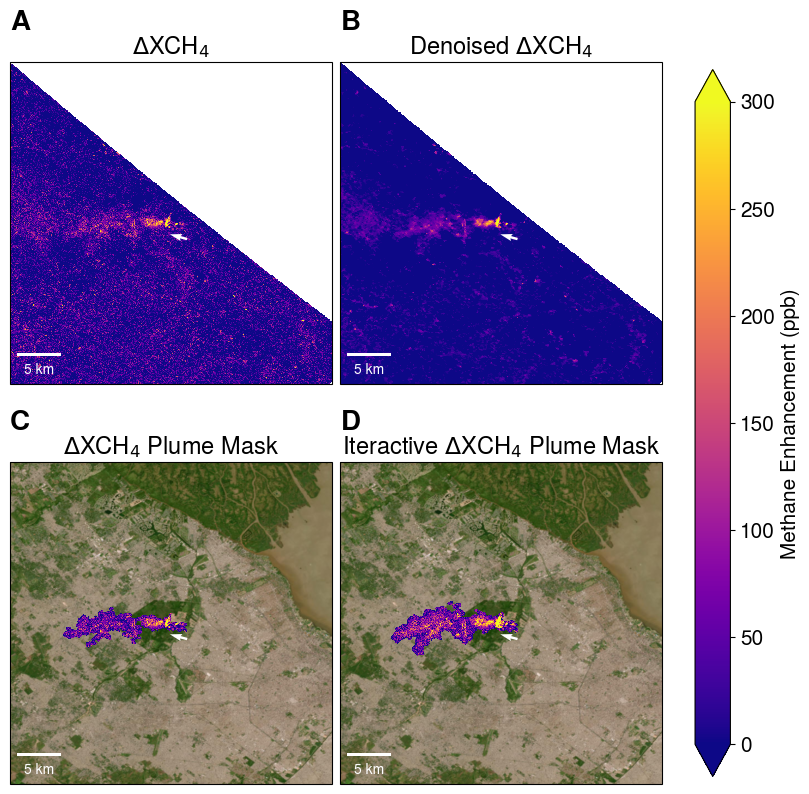

In [7]:
proj = ccrs.PlateCarree()

fig, axs = plt.subplots(nrows=2, ncols=2,
                        subplot_kw={'projection': proj},
                        figsize=(8, 8),
                        constrained_layout=True,
                        )

# axs_list = axs.ravel().tolist()

axs = axs.flatten()

# calculate the pad around source center
lon_min, lat_min, lon_max, lat_max = df['plume_bounds'].item()
lon_width = lon_max - lon_min
lat_width = lat_max - lat_min
# pad = max(lon_width, lat_width)
pad = 0.2

# set extent
lon_min = df['plume_longitude'] - pad
lon_max = df['plume_longitude'] + pad
lat_min = df['plume_latitude'] - pad
lat_max = df['plume_latitude'] + pad

for ax in axs:
    ax.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)

for ax in axs[2:]:
    cx.add_basemap(ax, crs=proj, source=cx.providers.Esri.WorldImagery)
    # remove watermark
    ax.texts[0].remove()

ax = axs[0]
# plot rgb and ch4 data
m = ds['ch4'].plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=300, cmap='plasma', add_colorbar=False, rasterized=True)

ax.set_title('$\Delta$XCH$_4$')

ax = axs[1]
# plot rgb and ch4 data
m = ds['ch4_comb_denoise'].plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=300, cmap='plasma', add_colorbar=False, rasterized=True)

# get wind info
u_era5 = ds_plume['u10'].sel(source='ERA5').mean()
v_era5 = ds_plume['v10'].sel(source='ERA5').mean()
wspd_era5 = np.sqrt(u_era5**2+v_era5**2).item()

ax.set_title('Denoised $\Delta$XCH$_4$')

# ax = axs[2]
# m = ch4_weights.plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=300, cmap='plasma', add_colorbar=False, rasterized=True)
# ax.set_title('Denoised $\Delta$XCH$_4$ * Wind Weights')

ax = axs[2]
m = ds_plume['ch4'].plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=300, cmap='plasma', add_colorbar=False, rasterized=True)
ax.set_title('$\Delta$XCH$_4$ Plume Mask')

ax = axs[3]
m = ds_plume_final['ch4'].plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=300, cmap='plasma', add_colorbar=False, rasterized=True)
ax.set_title('Iteractive $\Delta$XCH$_4$ Plume Mask')

fig.colorbar(m, ax=axs, extend='both', label='Methane Enhancement (ppb)', shrink=0.95)

for n, ax in enumerate(axs):
    # plot wind quivers
    q_era5 = ax.quiver(lon_target+pad/10, lat_target-pad/10,
                        u_era5, v_era5, transform=proj, color='w',
                        )
    ax.text(0, 1.1, string.ascii_uppercase[n],
            transform=ax.transAxes, 
            size=20, weight='bold')
    ax.add_artist(ScaleBar(distance_meters, location='lower left', color='w', frameon=False))

fig.savefig('../figures/plume_mask.pdf')